# Récupération des mask

"Future vision transport" conçoit des systèmes embarqués de vision par ordinateur pour les véhicules autonommes.
<img src="./img/logo_future_vision_transport.png" width="400px">

Le but de ce projet et de concevoir un système embarqué qui permet l'aquicisition d'image, le traitement des images, la segmentation des images puis un système de décision en bout de chaîne.

Mon role ici est de fournir une segmentation sémantique des images dans le but de facilité le système de décision dans ces choix. 

<img src="./img/logo_cityscapes.png" width="400px">

Pour ça, on utilisera le jeu de données CityScapes qui fournie un jeu de données de 3000 images d'une caméra embarqué avec un ensemble de masque avec les différent label de segmentation comme détailé <a href="https://www.cityscapes-dataset.com/dataset-overview/">ici </a>.

Voici un exemple de rendu que l'on souhaite obtenir :
<img src="./img/example_segmentation_semantic.png" width="400px">

In [1]:
import cv2
import imgaug
import matplotlib.pyplot as plt
import os
import json
import function as fnct
import time
%matplotlib inline

In [2]:
dir_y = "./data/gtFine/"
dir_x = "./data/leftImg8bit/"

Voici un exemple de la structure des fichier que l'on récupére sur CityScapes Dataset :

In [3]:
print("-", dir_x)
for dir_ in os.listdir(dir_x):
    print("     |_",dir_)
    for dir_2 in os.listdir(dir_x + dir_):
        nb_file = len(os.listdir(dir_x + dir_ +"/"+ dir_2))
        print("         |___",dir_2, "(",nb_file,")")

- ./data/leftImg8bit/
     |_ test
         |___ berlin ( 544 )
         |___ bielefeld ( 181 )
         |___ bonn ( 46 )
         |___ leverkusen ( 58 )
         |___ mainz ( 298 )
         |___ munich ( 398 )
     |_ train
         |___ aachen ( 174 )
         |___ bochum ( 96 )
         |___ bremen ( 316 )
         |___ cologne ( 154 )
         |___ darmstadt ( 85 )
         |___ dusseldorf ( 221 )
         |___ erfurt ( 109 )
         |___ hamburg ( 248 )
         |___ hanover ( 196 )
         |___ jena ( 119 )
         |___ krefeld ( 99 )
         |___ monchengladbach ( 94 )
         |___ strasbourg ( 365 )
         |___ stuttgart ( 196 )
         |___ tubingen ( 144 )
         |___ ulm ( 95 )
         |___ weimar ( 142 )
         |___ zurich ( 122 )
     |_ val
         |___ frankfurt ( 267 )
         |___ lindau ( 59 )
         |___ munster ( 174 )


In [4]:
print("-", dir_y)
for dir_ in os.listdir(dir_y):
    print("     |_",dir_)
    for dir_2 in os.listdir(dir_y + dir_):
        nb_file = len(os.listdir(dir_y + dir_ +"/"+ dir_2))
        print("         |___",dir_2, "( total :",nb_file,"ET divisé par 4 :",nb_file//4,")")

- ./data/gtFine/
     |_ test
         |___ berlin ( total : 2176 ET divisé par 4 : 544 )
         |___ bielefeld ( total : 724 ET divisé par 4 : 181 )
         |___ bonn ( total : 184 ET divisé par 4 : 46 )
         |___ leverkusen ( total : 232 ET divisé par 4 : 58 )
         |___ mainz ( total : 1192 ET divisé par 4 : 298 )
         |___ munich ( total : 1592 ET divisé par 4 : 398 )
     |_ train
         |___ aachen ( total : 696 ET divisé par 4 : 174 )
         |___ bochum ( total : 384 ET divisé par 4 : 96 )
         |___ bremen ( total : 1264 ET divisé par 4 : 316 )
         |___ cologne ( total : 616 ET divisé par 4 : 154 )
         |___ darmstadt ( total : 340 ET divisé par 4 : 85 )
         |___ dusseldorf ( total : 884 ET divisé par 4 : 221 )
         |___ erfurt ( total : 436 ET divisé par 4 : 109 )
         |___ hamburg ( total : 992 ET divisé par 4 : 248 )
         |___ hanover ( total : 784 ET divisé par 4 : 196 )
         |___ jena ( total : 476 ET divisé par 4 : 119 )


In [5]:
dir_train = "train/"
all_directory = {}
for file in os.listdir(dir_y + dir_train):
    all_directory[file] = []

On retrouve la même strucutre sur les 2 dossiers "gtFine" et "leftImg8bit".
- gtFine correspond aux outputs c'est à dire au masque de notre segmentation sémantique
- leftImg8bit correspond aux inputs c'est à dire au image RGB récupérer de la vidéo de la dashcam d'un véhicule

Dans ces dossier on à ensuite 3 dossier qui correspond à une séparation des données en données d'entrainement (train) de validation (val) et un dossier de test (test)

Dans chacun de ces dossiers nous avons ensuite un dossier par ville ou le véhicule contenant la dashcam est passé.

Si on regarde la quantité de fichier entre le dossier d'input et d'output on remarque que nous avons 4 fois plus de masque que de données d'entrée exactement

In [6]:
for i in range(2):
    print("-",os.listdir(dir_x + dir_train + "aachen")[i])

- aachen_000000_000019_leftImg8bit.png
- aachen_000001_000019_leftImg8bit.png


In [7]:
for i in range(4):
    print("-",os.listdir(dir_y + dir_train + "aachen")[i])
print("")
for i in range(4,8):
    print("-",os.listdir(dir_y + dir_train + "aachen")[i])

- aachen_000000_000019_gtFine_color.png
- aachen_000000_000019_gtFine_instanceIds.png
- aachen_000000_000019_gtFine_labelIds.png
- aachen_000000_000019_gtFine_polygons.json

- aachen_000001_000019_gtFine_color.png
- aachen_000001_000019_gtFine_instanceIds.png
- aachen_000001_000019_gtFine_labelIds.png
- aachen_000001_000019_gtFine_polygons.json


On voit que les dossiers contiennent bien 4 fichiers pour une entrée (qui est composé par l'id d'image de la vidéo "00000**0**_000019" puis l'image 2 de la vidéo "00000**1**_000019")

On peux maintenant regarder comment sont constituer les images/fichiers .json

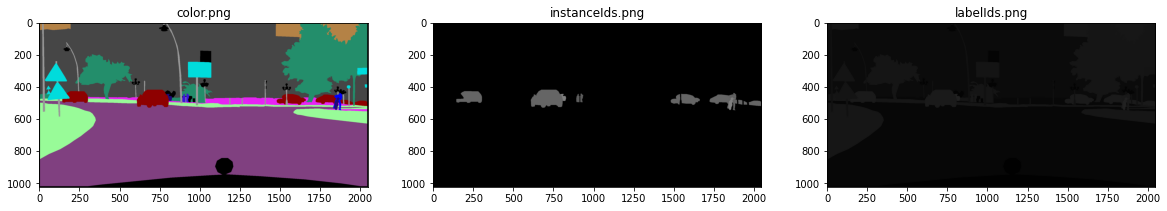

In [8]:
image_0 = cv2.imread(dir_y + dir_train + "aachen/" + "aachen_000000_000019_gtFine_color.png")
image_1 = cv2.imread(dir_y + dir_train + "aachen/" + "aachen_000000_000019_gtFine_instanceIds.png")
image_2 = cv2.imread(dir_y + dir_train + "aachen/" + "aachen_000000_000019_gtFine_labelIds.png")

fig, axs = plt.subplots(1,3,figsize=(20,20))
# fig.suptitle("Différence des mask .png")
axs[0].imshow(image_0)
axs[0].set_title("color.png")

axs[1].imshow(image_1)
axs[1].set_title("instanceIds.png")

axs[2].imshow(image_2)
axs[2].set_title("labelIds.png")

plt.show()

In [9]:
def convert(list):
    return tuple(list)
def count_color_rgb(image):
    all_color = {}
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            color =  convert(image[x,y].tolist())
            if not color in all_color.keys():
                all_color[color] = 1
            else:
                all_color[color] += 1
    return all_color

In [10]:
count_color_rgb(image_0)

{(0, 0, 0): 127841,
 (180, 130, 70): 38722,
 (153, 153, 153): 22846,
 (70, 70, 70): 611938,
 (35, 142, 107): 221654,
 (0, 220, 220): 34863,
 (142, 0, 0): 42659,
 (0, 0, 255): 2270,
 (60, 20, 220): 1588,
 (32, 11, 119): 2309,
 (232, 35, 244): 29195,
 (152, 251, 152): 130185,
 (128, 64, 128): 831082}

In [11]:
count_color_rgb(image_1)

{(0, 0, 0): 2048326,
 (101, 101, 101): 42659,
 (97, 97, 97): 2270,
 (93, 93, 93): 1588,
 (128, 128, 128): 2309}

In [12]:
count_color_rgb(image_2)

{(3, 3, 3): 31634,
 (23, 23, 23): 38722,
 (17, 17, 17): 22846,
 (11, 11, 11): 611938,
 (21, 21, 21): 221654,
 (4, 4, 4): 14664,
 (20, 20, 20): 34863,
 (26, 26, 26): 42659,
 (25, 25, 25): 2270,
 (24, 24, 24): 1588,
 (33, 33, 33): 2309,
 (8, 8, 8): 29195,
 (22, 22, 22): 130185,
 (7, 7, 7): 831082,
 (0, 0, 0): 9,
 (1, 1, 1): 81534}

On voit ici que l'image "...color.png" est bien disposé en RGB pour avoir un affichage en coleurs (une valeur distinct par channel).

Pour les 2 autre on retrouve 1 valeur unique pour chaque channel et donc des images plus sombre.
- Pour le fichier "...instanceId.png" toutes les identifiant de masque **ne sont pas inclus ont vas donc éliminer ce fichier pour la suite**.
- pour le fichier "...labelId.png" toutes valeurs sont retranscrite sous forme d'ID de 0 à 33.

On remarque également que l'image "...color.png" est identique à celle de labelId, par exemple la couleur de l'image (70,70,70) correspond à l'id 11 => (11,11,11)

In [13]:
def get_all_json_file(path_root_dir : str):
    all_file=[]
    for file in os.listdir(path_root_dir):
        split_file= file.split(".")
        if split_file[len(split_file) - 1] == 'json':
            all_file.append(path_root_dir + "/" + file)
    return all_file

In [14]:
for directory, files in all_directory.items():
    files.extend(get_all_json_file(dir_y + dir_train + directory))

In [15]:
path_file = all_directory["aachen"][0]
with open(path_file) as read:
    test = json.load(read)
    print("Première clé du fichier :")
    print(test.keys())
    print('')
    print("Contenue d'un object :")
    print(test["objects"][0].keys())
    print('')
    print("label",test["objects"][0]["label"])
    print("polygon",test["objects"][0]["polygon"])

Première clé du fichier :
dict_keys(['imgHeight', 'imgWidth', 'objects'])

Contenue d'un object :
dict_keys(['label', 'polygon'])

label road
polygon [[0, 769], [290, 574], [93, 528], [0, 524], [0, 448], [0, 448], [210, 453], [511, 451], [782, 459], [892, 495], [943, 498], [1044, 471], [1490, 486], [1880, 519], [1922, 512], [1975, 522], [2047, 524], [2047, 570], [1668, 553], [2047, 597], [2047, 1023], [892, 1023], [0, 1023]]


On regarde si les objets contiennent d'autre forme que "polygon"

In [16]:
%%time
value_other = []
for json_files in all_directory.values():
    for path_file in json_files:
        with open(path_file) as read:
            test = json.load(read)
            for obj in test["objects"]:
                if list(obj.keys())[1] != "polygon":
                    value_other.append(obj.keys()[1])

CPU times: user 3.64 s, sys: 1.14 s, total: 4.78 s
Wall time: 22.8 s


In [17]:
print(value_other)

[]


In [18]:
%%time
all_labels_counts={}
for json_files in all_directory.values():
    for path_file in json_files:
        with open(path_file) as read:
            test = json.load(read)
            for obj in test["objects"]:
                label = obj[list(obj.keys())[0]]
                if label in all_labels_counts.keys():
                    all_labels_counts[label] +=1
                else:
                    all_labels_counts[label] =1

CPU times: user 3.61 s, sys: 1.21 s, total: 4.81 s
Wall time: 12.9 s


In [19]:
all_segment = list(all_labels_counts.keys())
print(sorted(all_segment))

['bicycle', 'bicyclegroup', 'bridge', 'building', 'bus', 'car', 'caravan', 'cargroup', 'dynamic', 'ego vehicle', 'fence', 'ground', 'guard rail', 'license plate', 'motorcycle', 'motorcyclegroup', 'out of roi', 'parking', 'person', 'persongroup', 'pole', 'polegroup', 'rail track', 'rectification border', 'rider', 'ridergroup', 'road', 'sidewalk', 'sky', 'static', 'terrain', 'traffic light', 'traffic sign', 'trailer', 'train', 'truck', 'truckgroup', 'tunnel', 'vegetation', 'wall']


Tous les label sont disponnible sur le site <a href="https://www.cityscapes-dataset.com/dataset-overview/">cityscape dataset</a>.

On retrouve tout de même 5 nouveaux labels qui n'apparaisent pas directment dans les références : 
- ego vehicle =>  véhicule du conducteur
- license plate => plaque d'immatriculation
- out of roi => bordure
- rectification border => Problème sur l'image, réctification
- xxxxxgroup => délimitation fine entre plusieurs xxxxx et donc regrouper en "groupe"


On souhaite à la fin n'avoir plus que 8 catégories :
- void
- vechicule 
- flat
- construction
- object
- nature
- sky
- human

In [20]:
cats = {
     'bicycle':'vehicle',
     'bicyclegroup':'vehicle',
     'bridge':'construction',
     'building':'construction',
     'bus':'vehicle',
     'car':'vehicle',
     'caravan':'vehicle',
     'cargroup':'vehicle',
     'dynamic':'void',
     'ego vehicle':'void',
     'fence':'construction',
     'ground':'void',
     'guard rail':'construction',
     'license plate':'vehicle',
     'motorcycle':'vehicle',
     'motorcyclegroup':'vehicle',
     'out of roi':'void',
     'parking':'flat',
     'person':'human',
     'persongroup':'human',
     'pole':'object',
     'polegroup':'object',
     'rail track':'construction',
     'rectification border':'void',
     'rider':'human',
     'ridergroup':'human',
     'road':'flat',
     'sidewalk':'flat',
     'sky':'sky',
     'static':'void',
     'terrain':'nature',
     'traffic light':'object',
     'traffic sign':'object',
     'trailer':'vehicle',
     'train':'vehicle',
     'truck':'vehicle',
     'truckgroup':'vehicle',
     'tunnel':'construction',
     'vegetation':'nature',
     'wall':'construction'
}

cats_id_color= {
    'void':(0,0,0),
    'flat':(255,0,0),
    'construction':(200,200,200),
    'object':(120,0,120),
    'nature':(100,100,100),
    'sky':(0,255,0),
    'human':(200,200,0),
    'vehicle':(0,0,255)
}

cats_id_json= {
    'void':(0),
    'flat':(1),
    'construction':(2),
    'object':(3),
    'nature':(4),
    'sky':(5),
    'human':(6),
    'vehicle':(7)
}

cats_id_json_one_hot= {
    'void':        (1,0,0,0,0,0,0,0),
    'flat':        (0,1,0,0,0,0,0,0),
    'construction':(0,0,1,0,0,0,0,0),
    'object':      (0,0,0,1,0,0,0,0),
    'nature':      (0,0,0,0,1,0,0,0),
    'sky':         (0,0,0,0,0,1,0,0),
    'human':       (0,0,0,0,0,0,1,0),
    'vehicle':     (0,0,0,0,0,0,0,1)
}

## Test des 2 méthodes de récupération de masque

Dans ce test on essaiera les 2 différentes méthode de récupération de masque (2 type de fichier):
- Le fichier labelid.png qui est simillaire au color.png
- Le fichier JSON qui contient les information des différents masques

Pour ce faire on utilisera 2 mesures, la création/récupération du mask et la mise en forme en one_hot_encoder.

Bien evidament on souhaite le moyen le plus performant d'obtenir le masque final, c'est-à-dire, avec seulement 8 catégories

### Depuis le fichier JSON

In [21]:
from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.polys import Polygon
import numpy as np

import imgaug as ia

def draw_on_mask(mask,obj,dic_label,dic_color,image_shape,default_value='void'):
    polygon = obj["polygon"]
    label = obj["label"]
    if label in cats.keys():
        final_label = dic_label[label]
    else:
        final_label = default_value
    # On redessine tout les polygon sur le mask vierge
    test_xy = np.float32(polygon)
    key_point = KeypointsOnImage.from_xy_array(test_xy, shape=image_shape)
    poly = Polygon(key_point.keypoints)
    mask = poly.draw_on_image(mask,
                              color=dic_color[final_label],
                              alpha=1.0, alpha_lines=0.0, alpha_points=0.0,alpha_face=1.0)
    return mask

def get_mask_from_file_json(files_json:str,color:bool=True,with_one_hot_encoder:bool=False):
    with open(path_file) as read:
        test = json.load(read)
        imgHeight = int(test["imgHeight"])
        imgWidth = int(test["imgWidth"])
        # Création d'un mask vierge
        if color:
            image_shape = (imgHeight,imgWidth, 3)
            segmap = np.zeros(image_shape, dtype=np.uint8)
            for obj in test["objects"]:
                segmap = draw_on_mask(segmap,obj,cats,cats_id_color,image_shape)
        else:
            if with_one_hot_encoder:
                image_shape = (imgHeight,imgWidth, len(cats_id_json_one_hot.keys()))
                segmap = np.zeros(image_shape, dtype=np.uint8)
                for obj in test["objects"]:
                    segmap = draw_on_mask(segmap,obj,cats,cats_id_json_one_hot,image_shape)
            else:
                image_shape= (imgHeight,imgWidth, 1)
                segmap = np.zeros(image_shape, dtype=np.uint8)
                for obj in test["objects"]:
                    segmap = draw_on_mask(segmap,obj,cats,cats_id_json,image_shape)
    return segmap

In [22]:
%%time
path_file = all_directory["aachen"][0]
mask_color = get_mask_from_file_json(path_file,color=True)
mask_id = get_mask_from_file_json(path_file,color=False,with_one_hot_encoder=False)
mask_id_one_hot = get_mask_from_file_json(path_file,color=False,with_one_hot_encoder=True)

CPU times: user 6.97 s, sys: 1.9 s, total: 8.87 s
Wall time: 8.92 s


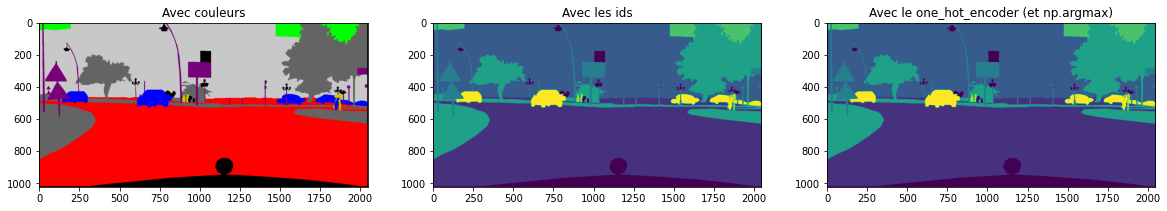

In [23]:
fig, axs = plt.subplots(1,3,figsize=(20,20))
# fig.suptitle("Différence des mask .png")
axs[0].imshow(mask_color)
axs[0].set_title("Avec couleurs")

axs[1].imshow(mask_id)
axs[1].set_title("Avec les ids")

axs[2].imshow(np.argmax(mask_id_one_hot,axis=2))
axs[2].set_title("Avec le one_hot_encoder (et np.argmax)")

plt.show()

### Benchmark

In [24]:
i = 0
SAMPLE_IMAGE = 100
all_path_to_benchmark = []
for json_files in all_directory.values():
    for path_file in json_files:
        if i < SAMPLE_IMAGE:
            all_path_to_benchmark.append(path_file)
        else:
            break;
        i+=1

In [25]:
def benchmark_json_file(all_path,one_hot_encoder):
    all_record_time = []
    for file in all_path:
        start_loop = time.time()
        # do function here
        _=get_mask_from_file_json(path_file,color=False,with_one_hot_encoder=one_hot_encoder)
        all_record_time.append(time.time() - start_loop)
    return all_record_time

In [26]:
record = benchmark_json_file(all_path_to_benchmark,one_hot_encoder=False)
record_one_hot = benchmark_json_file(all_path_to_benchmark,one_hot_encoder=True)

In [27]:
def benchmark_result(record,precision=4):
    record = np.asarray(record)
    print(f"- Dimension de l'échantillion : {record.shape[0]}")
    print(f"- Temps total : {round(record.sum(),precision)}s")
    print(f"- Temps moyen : {round(record.mean(),precision)}s")
    print(f"- Ecart type  : {round(record.std(),precision)}s")

In [28]:
print("Benchmark label ids méthode :")
benchmark_result(record)
print()
print("Benchmark one_hot_encoder méthode :")
benchmark_result(record_one_hot)

Benchmark label ids méthode :
- Dimension de l'échantillion : 100
- Temps total : 85.4764s
- Temps moyen : 0.8548s
- Ecart type  : 0.0113s

Benchmark one_hot_encoder méthode :
- Dimension de l'échantillion : 100
- Temps total : 457.5792s
- Temps moyen : 4.5758s
- Ecart type  : 0.0731s


In [30]:
json_mean_ohe = round(np.asarray(record_one_hot).mean(),4)
json_mean_le = round(np.asarray(record).mean(),4)

## Depuis le fichier Labelids

### Benchmark méthode d'ouverture (cv2, Pillow)

In [31]:
# On récupére toutes les images LabelIds
train_set,val_set,test_set = fnct.get_all_file(dir_y)

Temp pour récupérer les paths : 0.15s


In [32]:
merge = []
merge.extend(train_set)
merge.extend(val_set)
merge.extend(test_set)

In [33]:
SAMPLE_IMAGE_TO_OPEN = 1000

In [34]:
all_path_to_benchmark_png = []
i=0
for path_file in merge:
    if i < SAMPLE_IMAGE_TO_OPEN:
        all_path_to_benchmark_png.append(path_file)
    else:
        break;
    i+=1

In [35]:
all_path_to_benchmark_png[:5]

['./data/gtFine/train/aachen/aachen_000000_000019_gtFine_labelIds.png',
 './data/gtFine/train/aachen/aachen_000001_000019_gtFine_labelIds.png',
 './data/gtFine/train/aachen/aachen_000002_000019_gtFine_labelIds.png',
 './data/gtFine/train/aachen/aachen_000003_000019_gtFine_labelIds.png',
 './data/gtFine/train/aachen/aachen_000004_000019_gtFine_labelIds.png']

In [36]:
from PIL import Image
def benchmark_open_png(all_path,cv_method):
    all_record_time = []
    if cv_method:
        for file in all_path:
            start_loop = time.time()
            # do function here
            _ = cv2.imread(file,0)
            all_record_time.append(time.time() - start_loop)
    else:
        for file in all_path:
            start_loop = time.time()
            # do function here
            _ = np.array(Image.open(file))
            all_record_time.append(time.time() - start_loop)
    return all_record_time

In [37]:
all_record_time = benchmark_open_png(all_path_to_benchmark_png,cv_method=False)
all_record_time_cv2 = benchmark_open_png(all_path_to_benchmark_png,cv_method=True)

In [38]:
print("Benchmark Pillow méthode :")
benchmark_result(all_record_time)
print()
print("Benchmark CV2 méthode :")
benchmark_result(all_record_time_cv2)

Benchmark Pillow méthode :
- Dimension de l'échantillion : 1000
- Temps total : 12.9225s
- Temps moyen : 0.0129s
- Ecart type  : 0.002s

Benchmark CV2 méthode :
- Dimension de l'échantillion : 1000
- Temps total : 12.7631s
- Temps moyen : 0.0128s
- Ecart type  : 0.001s


### Affichage des mask

In [39]:
%%time
path_file=all_path_to_benchmark_png[0]
mask_id = fnct.get_image_labelid(path_file,one_hot_encoder=False)
mask_id_one_hot = fnct.get_image_labelid(path_file,one_hot_encoder=True)

CPU times: user 351 ms, sys: 0 ns, total: 351 ms
Wall time: 363 ms


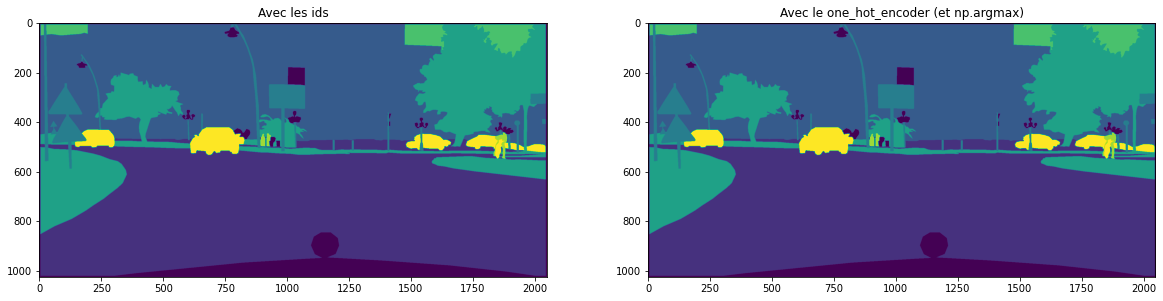

In [40]:
fig, axs = plt.subplots(1,2,figsize=(20,20))

axs[0].imshow(mask_id)
axs[0].set_title("Avec les ids")

axs[1].imshow(np.argmax(mask_id_one_hot,axis=2))
axs[1].set_title("Avec le one_hot_encoder (et np.argmax)")

plt.show()

### Bencharmk

In [41]:
all_path_to_benchmark_png = []
i=0
for path_file in merge:
    if i < SAMPLE_IMAGE:
        all_path_to_benchmark_png.append(path_file)
    else:
        break;
    i+=1

In [42]:
def benchmark_label_id(all_path,one_hot_encoder):
    all_record_time = []
    for file in all_path:
        start_loop = time.time()
        # do function here
        _ = fnct.get_image_labelid(file,one_hot_encoder=one_hot_encoder)
        all_record_time.append(time.time() - start_loop)
        
    return all_record_time

In [43]:
record_labelid = benchmark_label_id(all_path_to_benchmark_png,one_hot_encoder=False)
record_one_hot_labelid = benchmark_label_id(all_path_to_benchmark_png,one_hot_encoder=True)

In [44]:
print("Benchmark label ids méthode :")
benchmark_result(record_labelid)
print()
print("Benchmark one_hot_encoder méthode :")
benchmark_result(record_one_hot_labelid)

Benchmark label ids méthode :
- Dimension de l'échantillion : 100
- Temps total : 19.4589s
- Temps moyen : 0.1946s
- Ecart type  : 0.0032s

Benchmark one_hot_encoder méthode :
- Dimension de l'échantillion : 100
- Temps total : 18.7592s
- Temps moyen : 0.1876s
- Ecart type  : 0.0199s


In [45]:
png_mean_ohe = round(np.asarray(record_one_hot_labelid).mean(),4)
png_mean_le = round(np.asarray(record_labelid).mean(),4)

# Conclusion

In [46]:
import pandas as pd
result_final = {
    "label_ids":{"label_encoder":png_mean_le,"one_hot_encoder":png_mean_ohe},
    "json_file":{"label_encoder":json_mean_le,"one_hot_encoder":json_mean_ohe}
}

tab_comparatif = pd.DataFrame(result_final)
tab_comparatif["gain_seconde_labelid_vs_json"] = tab_comparatif["json_file"] - tab_comparatif["label_ids"]
tab_comparatif

,label_ids,json_file,gain_seconde_labelid_vs_json
label_encoder,0.1946,0.8548,0.6602
one_hot_encoder,0.1876,4.5758,4.3882


On vois sur le tableau comparatif que la récupération du fichier labelids et bien plus performante que la création avec le fichier json du masque from scratch

le résultat est flagrant sur le fichier one_hot_encoder qui prend environ 4 seconde seconde de plus avec le fichier json (0.2 seconde environ contre 4.6 seconde environ pour le fichier json).